Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.models import Model, Sequential
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize,stem,punkt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
import lightgbm as lgb
import nltk
from nltk.util import ngrams
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('punkt')
nltk.download('wordnet')


Output hidden; open in https://colab.research.google.com to view.

In this notebook we used LSTM+ XGBoost to predict the accident level.

This happens in 2 stages.
1. Process the description using 200d glove embeddings and pass them to LSTM for accident class probabilities.
2. Pass the probabilities along with other Non text parameters to XGBoost machine learning model to predict the final outcome.

# Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Setting the current working directory

import os; 
os.chdir('/content/drive/MyDrive/Colab Notebooks/Capstone/Final')


In [4]:
import pandas as pd
#ram 
#data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset.csv")
#satya path /content/drive/MyDrive/Capstone project/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv
data_orig = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset.csv")
# pd.read_csv("/content/drive/MyDrive/Capstone project/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv") #regular
#smote data load below 
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/Final/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset_SMOTE.csv")
data.head(3)


,Unnamed: 0,Data,Countries,Local,Industry Sector,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description,Accident Level
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,I
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,I
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,I


In [5]:
data_orig.shape

(425, 11)

In [6]:
data_bkp = data.copy()

In [7]:
data.rename(columns=
            {'Data':'Date','Genre':'Gender','Industry Sector':'Industry','Accident Level':'Accident','Potential Accident Level':'Potential_Accident','Employee or Third Party':'Emp_Type','Critical Risk':'Critical Risk'},inplace=True)


In [8]:
data_orig.rename(columns=
            {'Data':'Date','Genre':'Gender','Industry Sector':'Industry','Accident Level':'Accident','Potential Accident Level':'Potential_Accident','Employee or Third Party':'Emp_Type','Critical Risk':'Critical Risk'},inplace=True)


In [9]:
data.head(2)

,Unnamed: 0,Date,Countries,Local,Industry,Potential_Accident,Gender,Emp_Type,Critical Risk,Description,Accident
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,I
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,I


## Target

In [10]:
risk_grade = {'I':0,'II':1,'III':2,'IV':3,'V':4,'VI':5}
data['Accident'] = pd.Series([risk_grade[x] for x in data['Accident']], index=data.index)


In [11]:
data['Accident']

0       0
1       0
2       0
3       0
4       3
       ..
1575    4
1576    4
1577    4
1578    4
1579    4
Name: Accident, Length: 1580, dtype: int64

In [12]:
data_orig['Accident']= pd.Series([risk_grade[x] for x in data_orig['Accident']], index=data_orig.index)

In [13]:
data_orig['Accident']

0      0
1      0
2      0
3      0
4      3
      ..
420    0
421    0
422    0
423    0
424    0
Name: Accident, Length: 425, dtype: int64

In [14]:
y=data['Accident']
y_orig=data['Accident']

In [15]:
data_x = data.drop(columns ='Accident',axis =1)

## Test train split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data_x, y, 
    test_size=0.2, random_state=1)


In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.3, random_state=0)

In [18]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(884, 10) (884,) (380, 10) (380,) (316, 10) (316,)


In [19]:
data_x_orig = data_orig.drop(columns ='Accident',axis =1)
y_orig=data_orig['Accident']
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    data_x_orig, y_orig, 
    test_size=0.2, random_state=1)
X_train_orig, X_val_orig, y_train_orig, y_val_orig = train_test_split(
    X_train_orig, y_train_orig, 
    test_size=0.3, random_state=0)
print(X_train_orig.shape,y_train_orig.shape,X_val_orig.shape,y_val_orig.shape,X_test_orig.shape,y_test_orig.shape)

(238, 10) (238,) (102, 10) (102,) (85, 10) (85,)


# Preprocessing

## Text transformation

In [20]:
from text_preprocess import * #(custom module)
import re
def clean_text(df, col):
	#print('--'*30); print('Converting headlines to lower case')
	new_col_name = "cleaned_" + str(col)
	#print(new_col_name)
	df.new_col_name = df[col].apply(lambda x : x.lower())
	#print(df.new_col_name[0])

	#print('Replacing apostrophes to the standard lexicons')
	df.new_col_name = df.new_col_name.apply(lambda x : replace_words(x))

	#print('Removing punctuations')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_punctuation(x))

	#print('Removing Numbers')
	df.new_col_name = df.new_col_name.apply(lambda x : ''.join([i for i in x if not i.isdigit()]))

	#print('Applying Lemmatizer')
	df.new_col_name = df.new_col_name.apply(lambda x: lem(x))

	#print('Removing multiple spaces between words')
	df.new_col_name = df.new_col_name.apply(lambda x: re.sub(' +', ' ', x))

	#print('Removing stopwords')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_stopwords(x))

	# remove short words (length < 3)
	#print('Removing short words')
	df.new_col_name = df.new_col_name.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
	#print('--'*30)
	return(df.new_col_name)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Date Transformation

In [21]:
from sklearn.base import BaseEstimator,TransformerMixin
import pandas as pd
class TemporalVariableEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X):
        X = X.copy()
       #print("X.shape:",X.shape)
       #print("X.head:",X.head())
       #print("[self.variables :",self.variables)
       #print("X[self.variables]['Date']",X[self.variables]['Date'])
       #print("X['Date']:",X['Date'])
       #print("pd.DatetimeIndex(X):",pd.DatetimeIndex(X[self.variables]['Date']))
        X['month'] = pd.DatetimeIndex(X[self.variables]['Date']).month
        X['year'] = pd.DatetimeIndex(X[self.variables]['Date']).year
        X['day'] = pd.DatetimeIndex(X[self.variables]['Date']).day
#        X['dayname'] = pd.DatetimeIndex(X[self.variables]['Date']).day_name()
        X['weekofyear'] = pd.Int64Index(pd.DatetimeIndex(X[self.variables]['Date']).isocalendar().week)  
       #print("###############################X.shape:",X.shape)
#        enc_attribs=["month", "year", "day","dayname","weekofyear"]
        enc_attribs=["month", "year", "day","weekofyear"]
        X=X.loc[:,enc_attribs]
       #print("enc Dateframe chk",X.head())
        ##X=X.drop('Date',inplace=True)
        #print("df columns",X.columns())
#        one_hot_pipeline= Pipeline([('one_hot_encoder',OneHotEncoder(drop='first'))])
#        X=one_hot_pipeline.fit_transform(X)
       #print("###############################X.shape:",X.shape)
 #      #print("###############################X.head:",X[0,:])
        #print('Date transformed.')
        return X

## Text tokenization and impute

1.   Risk Category
2.   Industry



In [22]:
from sklearn.base import BaseEstimator,TransformerMixin
import pickle
from sklearn.decomposition import PCA

class ImputeEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        pass
    
    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self
    

    def transform(self, X):
            X = X.copy()
            ##print(X.info())
            ## Lable encoder
            industry = {'Metals':1,'Mining':2,'Others':99}
            X['Industry'] = pd.Series([industry[x] for x in X['Industry']], index=X.index)

            #print('Industry Encoded')
            
            risk_map = {'\nNot applicable': 99,
            'Bees': 1,
            'Venomous Animals': 1,
            'Blocking and isolation of energies': 3,
            'Burn': 3,
            'Confined space': 3,
            'Cut': 3,
            'Machine Protection': 3,
            'Manual Tools': 3,
            'Poll': 3,
            'Projection': 3,
            'Projection of fragments': 3,
            'Projection/Burning': 3,
            'Projection/Choco': 3,
            'Projection/Manual Tools': 3,
            'remains of choco': 3,
            'Suspended Loads': 3,
            'Fall': 4,
            'Fall prevention': 4,
            'Fall prevention (same level)': 4,
            'Electrical installation': 5,
            'Electrical Shock': 5,
            'Plates': 5,
            'Power lock': 5,
            'Chemical substances': 6,
            'Liquid Metal': 7,
            'Pressed': 8,
            'Pressurized Systems': 8,
            'Pressurized Systems / Chemical Substances': 8,
            'Individual protection equipment': 9,
            'Traffic': 10,
            'Vehicles and Mobile Equipment': 11,
            'Others': 99}

            X['Critical Risk'] = pd.Series([risk_map[x] for x in X['Critical Risk']], index=X.index)

            #print('Critical Risk Encoded')

            #Y = X.copy()
           #print("X['Description']:",X['Description'])
            #print("pd.DatetimeIndex(X):",pd.DatetimeIndex(X[self.variables]['Data']))
            X['Cleaned_Description'] = clean_text(X,"Description")
            X_desc=X['Cleaned_Description']
           #print("Cleaned_Description",X_desc.head())
            from tensorflow.keras.preprocessing.text import Tokenizer
            tokenizer = Tokenizer (num_words = 100)
            tokenizer.fit_on_texts(list(X_desc))
            X_desc = tokenizer.texts_to_sequences(X_desc)
            #print('Cleaned text Tokenized.')

           #print("Tokenized",X_desc)
            #max_len=max( X['cleaned_Description'].apply(lambda x: len(x.split(' '))))
            max_len=100
           #print("max_len",max_len)
            X_pad = pad_sequences(X_desc, maxlen = max_len)
            X_final = pd.DataFrame(X_pad)
  #         #print("padded",X_pad[0,:])
            #print(text_encoded.head())
            #X = X[X['Critical Risk'] == 99]
            #print(X.shape)
            riskpred_model = 'predict_risk.pkl'
            riskpred_model = pickle.load(open(riskpred_model, 'rb'))
            pca=PCA(n_components=45)
            X_processed_pca=pca.fit_transform(X_pad)
            #print("predictions",X[0])
           #print("predictions",X_processed_pca.shape)
            X['predicted_risk'] = riskpred_model.predict(X_processed_pca)
            X['predicted_risk'] = X.apply(lambda x: x['predicted_risk'] if x['Critical Risk']==99 else x['Critical Risk'], axis=1)
            #print("new",Y.info())
           #print(X.head())
          # #print('predicted  risk shape1',X_pred_risk.shape)            
            X_pred_risk = X['predicted_risk'].values
           #print('predicted  risk values shape1',X_pred_risk.shape)             
            X_pred_risk = X_pred_risk.reshape(X_pred_risk.shape[0],1)

            #print('Risk Category imputation complete.')
            #print('predicted  risk shape2',X_pred_risk.shape)
            pca=PCA(n_components=45)
            X_processed_pca=pca.fit_transform(X_pad)
##
           
            indpred_model = 'predict_industry.pkl'
            indpred_model = pickle.load(open(indpred_model, 'rb'))
            X['predicted_ind'] = indpred_model.predict(X_processed_pca)
            X['predicted_ind'] = X.apply(lambda x: x['predicted_ind'] if x['Industry']==99 else x['Industry'], axis=1)
           #print('predicted ind',X['predicted_ind'])
            #print("new",Y.info())
           #print(X.tail(20))
            X_pred_ind = X['predicted_ind'].values
            X_pred_ind = X_pred_ind.reshape(X_pred_ind.shape[0],1)

            #print('Industry imputation complete.')

           #print('predicted shape',X_pred_ind.shape)
           ##print('padded X_pad',X_pad.type())
            X_final['pred_risk'] = X_pred_risk
            X_final['pred_ind'] = X_pred_ind
            X = X_final
           #print(X_final.shape)
            return X

## Column Encoder

1. Country
2. Local
3. Emp_Type
4. Potential Accident

In [23]:
from sklearn.base import BaseEstimator,TransformerMixin
import pandas as pd
class ColumnsLabelEncoder(BaseEstimator, TransformerMixin):
      
    def __init__(self, variables=None):
        
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X):
        X = X.copy()
       
        country = {'Country_01':1,'Country_02':2,'Country_03':3}
      
        local = { 'Local_01': 1,
                  'Local_02': 2,
                  'Local_03': 3,
                  'Local_04': 4,
                  'Local_05': 5,
                  'Local_06': 6,
                  'Local_07': 7,
                  'Local_08': 8,
                  'Local_09': 9,
                  'Local_10': 10,
                  'Local_11': 11,
                  'Local_12': 12 }

        emp = {
                  'Third Party': 1,
                  'Employee': 2,
                  'Third Party (Remote)': 3
        }
        
        risk_grade = {'I':1,'II':2,'III':3,'IV':4,'V':5,'VI':6}        
        

        X['Countries'] = pd.Series([country[x] for x in X['Countries']], index=X.index)
        #print('Countries Encoded')

        X['Local'] = pd.Series([local[x] for x in X['Local']], index=X.index)
        #print('Local Encoded')

        X['Emp_Type'] = pd.Series([emp[x] for x in X['Emp_Type']], index=X.index)
        #print('Emp_type Encoded')

        X['Potential_Accident'] = pd.Series([risk_grade[x] for x in data['Potential_Accident']], index=data.index)
        #print('Potential Accident Encoded')

       # X['Gender'] = pd.Series([country[x] for x in X['Gender']], index=X.index)
      #  X=X.loc[:,enc_attribs]
       #print("enc Dateframe chk",X.head())
       #print("###############################X.shape:",X.shape)
       ##print("###############################X.head:",X[0,:])
        return X

## Pipeline

In [24]:
#Building the Transformation Pipeline
from sklearn.pipeline import Pipeline
from  sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.decomposition import PCA
import numpy as np
#import skmice
dataframe=data
dataframe_x=dataframe.drop(['Accident'],axis=1)


#date pipeline##################################################
date_attribs=["Date"]
dataframe_date=dataframe.loc[:,date_attribs]
##print("dataframe_date chk" ,dataframe_date.head())
date_pipeline= Pipeline([('date_info_split', TemporalVariableEstimator(date_attribs))])
dataframe_date_tr=date_pipeline.fit_transform(dataframe_date)
#print("Date Pipeline check",dataframe_date_tr)
######################################################################

#OnehotEncoding Pipeline##############################################
#one_hot_attribs=["Local", "Industry", "Emp_Type","Countries","Potential_Accident","Gender"]
one_hot_attribs=["Gender"]
dataframe_onehot=dataframe.loc[:,one_hot_attribs]
#print("Onehot dataframe chk",dataframe_onehot.head())
one_hot_pipeline= Pipeline([('one_hot_encoder',OneHotEncoder(drop='first'))])
#one_hot_pipeline= Pipeline([('one_hot_encoder',LabelEncoder())])
dataframe_oh_tr=one_hot_pipeline.fit_transform(dataframe_onehot)
##print("Onehot Pipeline check",dataframe_oh_tr[0,1])
######################################################################
'''
#Text Pipeline##############################################
text_attribs=['Description']
dataframe_text_enc=dataframe.loc[:,text_attribs]
#print("Text encode  dataframe chk",dataframe_text_enc.head())
text_pipeline= Pipeline([('text_encoder',TextVariableEstimator())])
dataframe_text_enc_tr=text_pipeline.fit_transform(dataframe_text_enc)
#print("Text encoding Pipeline check",dataframe_text_enc_tr[0])
'''
#Risk Pipeline##############################################
risk_attribs=['Critical Risk','Industry','Description']
dataframe_risk_imp=dataframe.loc[:,risk_attribs]
#print("Impute  dataframe chk",dataframe_risk_imp.head())
risk_pipeline= Pipeline([('risk_imputer',ImputeEstimator())])
dataframe_risk_imp_tr=risk_pipeline.fit_transform(dataframe_risk_imp)
#print("Impute Pipeline check",dataframe_risk_imp_tr[0])

'''
#Industry Impute Pipeline###################################
ind_attribs=['Industry','Description']
dataframe_ind_imp=dataframe.loc[:,ind_attribs]
#print("Industry Impute  dataframe chk",dataframe_ind_imp.head())
ind_pipeline= Pipeline([('industry_imputer',IndustryImputeEstimator())])
dataframe_ind_imp_tr=ind_pipeline.fit_transform(dataframe_ind_imp)
#print("Industry Impute Pipeline check",dataframe_ind_imp_tr[0])
'''
#Lable encoder Pipeline##############################################
le_attribs=['Countries','Local','Emp_Type','Potential_Accident']
dataframe_le=dataframe.loc[:,le_attribs]
#print("LE  dataframe chk",dataframe_le.head())
le_pipeline= Pipeline([('risk_imputer',ColumnsLabelEncoder())])
dataframe_le_tr=le_pipeline.fit_transform(dataframe_le)
#print("LE Pipeline check",dataframe_le_tr[0:])

In [25]:
######################################################################
full_pipeline=ColumnTransformer([
                ("datetransform",date_pipeline,date_attribs),
                ("imputer",risk_pipeline, risk_attribs),
            #    ("industryimputer",ind_pipeline, ind_attribs),
            #    ("textencode",text_pipeline,text_attribs)  ,
                ("onehotencode",one_hot_pipeline, one_hot_attribs),
                ("le_encode",le_pipeline, le_attribs)
])
#dataframe_x_tr=full_pipeline.fit_transform(dataframe_x)
#dataframe_x_tr[0,:]


# Neural Nets

In [26]:
import tensorflow as tf
import keras
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import BatchNormalization,Dropout
from keras.layers import Activation

In [27]:
# Hyper Parameter Tuning for full data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

seed=42
nn_pipe_steps = [('data_transaform',full_pipeline), 
               ('scalar',StandardScaler())
            ]
nn_pipeline = Pipeline(nn_pipe_steps)

In [28]:
X_train_nn = nn_pipeline.fit_transform(X_train)
X_val_nn = nn_pipeline.fit_transform(X_val)
X_test_nn = nn_pipeline.fit_transform(X_test)

In [29]:
epochs=50 # 60
sgd = SGD()
input_dim = X_train_nn.shape[1]
batch_size = int(input_dim/10)

In [30]:
y_train_nn = tf.keras.utils.to_categorical(y_train, 6)
y_val_nn = tf.keras.utils.to_categorical(y_val, 6)
y_test_nn = tf.keras.utils.to_categorical(y_test, 6)

In [31]:
print('Final Tensors shape before training')
print('Training set', X_train_nn.shape, y_train_nn.shape)
print('Validation set', X_val_nn.shape, y_val_nn.shape)
print('Test set', X_test_nn.shape, y_test_nn.shape)

Final Tensors shape before training
Training set (884, 111) (884, 6)
Validation set (380, 111) (380, 6)
Test set (316, 111) (316, 6)


In [32]:
# build the model

seq = Sequential()
seq.add(Dense(256, input_dim = input_dim))
seq.add(Activation('relu'))    
seq.add(Dense(128))                 
seq.add(Activation('relu'))
seq.add(Dense(64))                   
seq.add(Activation('relu'))   
seq.add(Dense(64))                   
seq.add(Activation('relu'))  
seq.add(Dense(32))                   
seq.add(Activation('relu'))  
seq.add(Dense(6, activation=tf.nn.softmax))

# compile the model
seq.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

In [33]:
seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               28672     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4

In [34]:
%%time

simple_model_history = seq.fit(X_train_nn, y_train_nn,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val_nn, y_val_nn)
                    )

Epoch 1/50
81/81 [==============================] - 3s 9ms/step - loss: 1.6542 - acc: 0.2755 - val_loss: 1.1079 - val_acc: 0.4842
Epoch 2/50
81/81 [==============================] - 0s 4ms/step - loss: 0.9709 - acc: 0.5641 - val_loss: 1.0153 - val_acc: 0.5868
Epoch 3/50
81/81 [==============================] - 0s 4ms/step - loss: 0.8341 - acc: 0.6612 - val_loss: 0.9408 - val_acc: 0.6000
Epoch 4/50
81/81 [==============================] - 0s 4ms/step - loss: 0.7135 - acc: 0.7127 - val_loss: 0.9125 - val_acc: 0.6184
Epoch 5/50
81/81 [==============================] - 0s 6ms/step - loss: 0.6025 - acc: 0.7809 - val_loss: 0.9676 - val_acc: 0.6211
Epoch 6/50
81/81 [==============================] - 0s 4ms/step - loss: 0.5665 - acc: 0.7952 - val_loss: 0.9775 - val_acc: 0.5868
Epoch 7/50
81/81 [==============================] - 0s 4ms/step - loss: 0.4586 - acc: 0.8600 - val_loss: 1.1362 - val_acc: 0.5921
Epoch 8/50
81/81 [==============================] - 0s 4ms/step - loss: 0.4534 - acc: 0.81

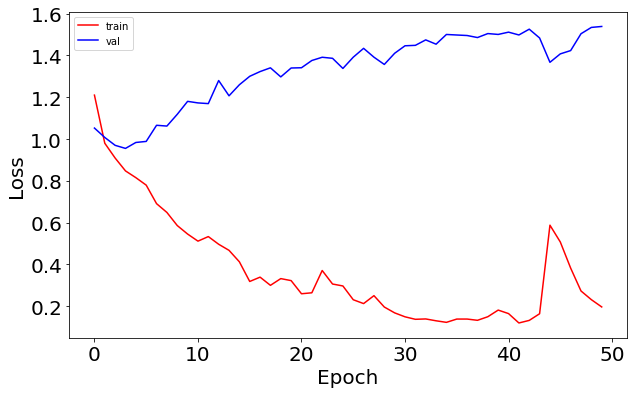

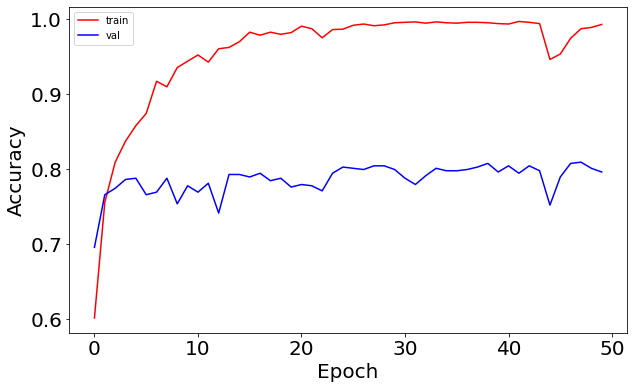

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(simple_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(simple_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(simple_model_history.history['acc']), 'r', label='train')
ax.plot(np.sqrt(simple_model_history.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [36]:
Simple_results = seq.evaluate(X_test_nn, y_test_nn)

10/10 [==============================] - 0s 2ms/step - loss: 3.1798 - acc: 0.6266


In [37]:
print('Test accuracy: ', Simple_results)

Test accuracy:  [3.1797797679901123, 0.6265822649002075]


In [38]:
max_features = 1000
maxlen = 111
embedding_size = 200

In [39]:
#ram EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/NLP/glove.6B.200d.txt'
#EMBEDDING_FILE = '/content/drive/MyDrive/glove.6B.200d.txt.zip'

#from zipfile import ZipFile
#glove_file='/content/drive/MyDrive/glove.6B.200d.txt.zip'
#with ZipFile(glove_file) as z:
#  z.extractall()

EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/NLP/glove.6B.200d.txt'
embeddings = {}
for o in open(EMBEDDING_FILE, encoding="utf8"):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

We need to convert our text to embedding vector

In [40]:
embedding_matrix = np.zeros((max_features, 200))
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer=Tokenizer(100)
for word, i in tokenizer.word_index.items():
  if i >= max_features:
        continue
  embedding_vector = embeddings.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

In [41]:

from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential


lstm_out = 128

# Define LSTM Model

model = Sequential()
model.add(Embedding(max_features, embedding_size, weights = [embedding_matrix]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(74, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         200000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 200)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense_6 (Dense)              (None, 74)                7474      
Total params: 327,874
Trainable params: 327,874
Non-trainable params: 0
_________________________________________________________________
None


# LSTM Model

# TextEstimator
class that Tokenizes and pads the description to 100 characters - to be used in Sklearn pipeline

In [42]:
from sklearn.base import BaseEstimator,TransformerMixin
import pickle
from sklearn.decomposition import PCA

class TextEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        pass
    
    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self
    

    def transform(self, X):
            X = X.copy()
            #print("X['Description']:",X['Description'])
            X['Cleaned_Description'] = clean_text(X,"Description")
            X_desc=X['Cleaned_Description']
            #print("Cleaned_Description",X_desc.head())
            tokenizer = Tokenizer (num_words = 2000)
            tokenizer.fit_on_texts(list(X_desc))
            #print ("#############tokenizer.word_index",tokenizer.word_index)
            X_desc = tokenizer.texts_to_sequences(X_desc)
            #print("Tokenized",X_desc)
            max_len=100
            #print("max_len",max_len)
            X_pad = pad_sequences(X_desc, maxlen = max_len)
            X = pd.DataFrame(X_pad)
            #print("X.shape **********",X.shape)
            #print(X.head(2))
            return X

In [43]:
#testing the text Pipeline##############################################
text_attribs=['Description']
dataframe_text=data.loc[:,text_attribs][0:2]
print("text  dataframe chk",dataframe_text.head())
text_pipeline= Pipeline([('text pipeline',TextEstimator())])
dataframe_text_tr=text_pipeline.fit_transform(dataframe_text)
print("Text Pipeline check",dataframe_text_tr)

text  dataframe chk                                          Description
0  While removing the drill rod of the Jumbo 08 f...
1  During the activation of a sodium sulphide pum...
Text Pipeline check    0   1   2   3   4   5   6   7   8   ...  91  92  93  94  95  96  97  98  99
0   0   0   0   0   0   0   0   0   0  ...  27   1  28  29   6  30   2  31   4
1   0   0   0   0   0   0   0   0   0  ...  48  49  50  51  52   7   8  53  54

[2 rows x 100 columns]


# OnlyImputeEstimator- 
class that imputes the Industry and critical risk based on the description - to be used in Sklearn pipeline

In [44]:
from sklearn.base import BaseEstimator,TransformerMixin
import pickle
from sklearn.decomposition import PCA

class OnlyImputeEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        pass
    
    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self
    

    def transform(self, X):
            X = X.copy()
            ##print(X.info())
            ## Lable encoder
            industry = {'Metals':1,'Mining':2,'Others':99}
            X['Industry'] = pd.Series([industry[x] for x in X['Industry']], index=X.index)

            #print('Industry Encoded')
            
            risk_map = {'\nNot applicable': 99,
            'Bees': 1,
            'Venomous Animals': 1,
            'Blocking and isolation of energies': 3,
            'Burn': 3,
            'Confined space': 3,
            'Cut': 3,
            'Machine Protection': 3,
            'Manual Tools': 3,
            'Poll': 3,
            'Projection': 3,
            'Projection of fragments': 3,
            'Projection/Burning': 3,
            'Projection/Choco': 3,
            'Projection/Manual Tools': 3,
            'remains of choco': 3,
            'Suspended Loads': 3,
            'Fall': 4,
            'Fall prevention': 4,
            'Fall prevention (same level)': 4,
            'Electrical installation': 5,
            'Electrical Shock': 5,
            'Plates': 5,
            'Power lock': 5,
            'Chemical substances': 6,
            'Liquid Metal': 7,
            'Pressed': 8,
            'Pressurized Systems': 8,
            'Pressurized Systems / Chemical Substances': 8,
            'Individual protection equipment': 9,
            'Traffic': 10,
            'Vehicles and Mobile Equipment': 11,
            'Others': 99}

            X['Critical Risk'] = pd.Series([risk_map[x] for x in X['Critical Risk']], index=X.index)

            #print('Critical Risk Encoded')

            #Y = X.copy()
           #print("X['Description']:",X['Description'])
            #print("pd.DatetimeIndex(X):",pd.DatetimeIndex(X[self.variables]['Data']))
            X['Cleaned_Description'] = clean_text(X,"Description")
            X_desc=X['Cleaned_Description']
           #print("Cleaned_Description",X_desc.head())
            tokenizer = Tokenizer (num_words = 100)
            tokenizer.fit_on_texts(list(X_desc))
            X_desc = tokenizer.texts_to_sequences(X_desc)
            #print('Cleaned text Tokenized.')

           #print("Tokenized",X_desc)
            #max_len=max( X['cleaned_Description'].apply(lambda x: len(x.split(' '))))
            max_len=100
           #print("max_len",max_len)
            X_pad = pad_sequences(X_desc, maxlen = max_len)
            X_final = pd.DataFrame(X_pad)
  #         #print("padded",X_pad[0,:])
            #print(text_encoded.head())
            #X = X[X['Critical Risk'] == 99]
            #print(X.shape)
            riskpred_model = 'predict_risk.pkl'
            riskpred_model = pickle.load(open(riskpred_model, 'rb'))
            pca=PCA(n_components=45)
            X_processed_pca=pca.fit_transform(X_pad)
            #print("predictions",X[0])
           #print("predictions",X_processed_pca.shape)
            X['predicted_risk'] = riskpred_model.predict(X_processed_pca)
            X['predicted_risk'] = X.apply(lambda x: x['predicted_risk'] if x['Critical Risk']==99 else x['Critical Risk'], axis=1)
            #print("new",Y.info())
           #print(X.head())
          # #print('predicted  risk shape1',X_pred_risk.shape)            
            X_pred_risk = X['predicted_risk'].values
           #print('predicted  risk values shape1',X_pred_risk.shape)             
            #X_pred_risk = X_pred_risk.reshape(X_pred_risk.shape[0],1)

            print('Risk Category imputation complete.')
            #print('predicted  risk shape2',X_pred_risk.shape)
            pca=PCA(n_components=45)
            X_processed_pca=pca.fit_transform(X_pad)
##
           
            indpred_model = 'predict_industry.pkl'
            indpred_model = pickle.load(open(indpred_model, 'rb'))
            X['predicted_ind'] = indpred_model.predict(X_processed_pca)
            X['predicted_ind'] = X.apply(lambda x: x['predicted_ind'] if x['Industry']==99 else x['Industry'], axis=1)
           #print('predicted ind',X['predicted_ind'])
            #print("new",Y.info())
           #print(X.tail(20))
            X_pred_ind = X['predicted_ind'].values
            #X_pred_ind = X_pred_ind.reshape(X_pred_ind.shape[0],1)

            #print('Industry imputation complete.')

           #print('predicted shape',X_pred_ind.shape)
           ##print('padded X_pad',X_pad.type())
            X_final=pd.DataFrame()
            #print('X_pred_risk shape',X_pred_risk.shape)
            #print('X_pred_ind shape',X_pred_ind.shape)
            X_final['pred_risk'] = X_pred_risk
            X_final['pred_ind'] = X_pred_ind
            X = X_final
           #print(X_final.shape)
            return X

In [45]:
#Testing the OnlyImpue Estimator Pipeline##############################################
impute_attribs=['Critical Risk','Industry','Description']
dataframe_risk_imp=dataframe.loc[:,impute_attribs]
impute_pipeline= Pipeline([('imputer',OnlyImputeEstimator())])
dataframe_risk_imp_tr=impute_pipeline.fit_transform(dataframe_risk_imp)
print(dataframe_risk_imp_tr)

Risk Category imputation complete.
      pred_risk  pred_ind
0             8         2
1             8         2
2             3         2
3             5         2
4             1         2
...         ...       ...
1575          5         1
1576          1         2
1577          3         2
1578          3         2
1579          5         1

[1580 rows x 2 columns]


# # Non text pipeline - 
pipeline that preprocesses all the columns except description - performs - date column transformation, Imputation of Risk and Industry, one ot encodes the gender columns and label encodes all other categorical columns

In [46]:
######################################################################
all_attribs=date_attribs+impute_attribs+one_hot_attribs+le_attribs
non_text_pipeline=ColumnTransformer([
                ("datetransform",date_pipeline,date_attribs),
                ("imputer",impute_pipeline, impute_attribs),
            #    ("industryimputer",ind_pipeline, ind_attribs),
            #    ("textencode",text_pipeline,text_attribs)  ,
                ("onehotencode",one_hot_pipeline, one_hot_attribs),
                ("le_encode",le_pipeline, le_attribs)
               # ("scaler",StandardScaler(),all_attribs)
])


In [48]:
'''from zipfile import ZipFile
glove_file='/content/drive/MyDrive/glove.6B.200d.txt.zip'
with ZipFile(glove_file) as z:
  z.extractall()
  '''

"from zipfile import ZipFile\nglove_file='/content/drive/MyDrive/glove.6B.200d.txt.zip'\nwith ZipFile(glove_file) as z:\n  z.extractall()\n  "

# Creating the embedding matrix

In [49]:
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/NLP/glove.6B.200d.txt'
vocabSize = 10000
tokenizer = Tokenizer(num_words=vocabSize, split=' ')

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
num_words=100
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:        
		embedding_matrix[i] = embedding_vector

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional,Flatten,Dropout

embed_dim = 100
lstm_out = 196
vocabSize=10000

model = Sequential()
model.add(Embedding(vocabSize, embed_dim))
model.add(SpatialDropout1D(0.3))
model.add(Dense(100,activation='relu'))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(5,activation='softmax'))

In [51]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 100)         0         
_________________________________________________________________
dense_7 (Dense)              (None, None, 100)         10100     
_________________________________________________________________
bidirectional (Bidirectional (None, 392)               465696    
_________________________________________________________________
dense_8 (Dense)              (None, 100)               39300     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)              

In [52]:
X_train_orig_text=text_pipeline.fit_transform(X_train_orig)
print(X_train_orig_text.shape)
X_val_orig_text=text_pipeline.fit_transform(X_val_orig)
print(X_val_orig_text.shape)
X_test_orig_text=text_pipeline.fit_transform(X_test_orig)

(238, 100)
(102, 100)


In [53]:
X_train_text=text_pipeline.fit_transform(X_train)
X_val_text=text_pipeline.fit_transform(X_val)
X_test_text=text_pipeline.fit_transform(X_test)

In [54]:
#### Add your code here ####
# Use earlystopping
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
#callback = tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, min_delta=0.01)
batch_size=32
es=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)
mc = ModelCheckpoint('lstm_model_pred.h5'
                , monitor = 'val_loss'
                , mode = 'min', save_best_only = True, verbose = 1) 
lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.01, patience = 5)  
callbacks = [es, mc, lr_r  ]

# Fit the model
history=model.fit(X_train_orig_text,y_train_orig, validation_data=(X_val_orig_text, y_val_orig), epochs=10, batch_size=batch_size, callbacks=callbacks)




Epoch 1/10
8/8 [==============================] - 11s 880ms/step - loss: 1.5178 - accuracy: 0.4300 - val_loss: 0.9075 - val_accuracy: 0.7549

Epoch 00001: val_loss improved from inf to 0.90746, saving model to lstm_model_pred.h5
Epoch 2/10
8/8 [==============================] - 7s 827ms/step - loss: 1.0812 - accuracy: 0.7136 - val_loss: 0.9515 - val_accuracy: 0.7549

Epoch 00002: val_loss did not improve from 0.90746
Epoch 3/10
8/8 [==============================] - 7s 827ms/step - loss: 0.9746 - accuracy: 0.7294 - val_loss: 0.9018 - val_accuracy: 0.7549

Epoch 00003: val_loss improved from 0.90746 to 0.90177, saving model to lstm_model_pred.h5
Epoch 4/10
8/8 [==============================] - 6s 814ms/step - loss: 0.9889 - accuracy: 0.7322 - val_loss: 0.9362 - val_accuracy: 0.7549

Epoch 00004: val_loss did not improve from 0.90177


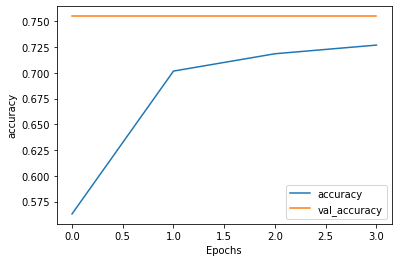

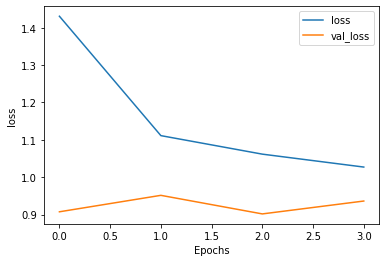

In [55]:
def graph_plots(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
graph_plots(history, "accuracy")
graph_plots(history, "loss")

In [56]:
! pip install h5py

In [57]:
# serialize lstm_pred_model to JSON
lstm_pred_model=model
lstm_pred_model_json = lstm_pred_model.to_json()
with open("lstm_pred_model.json", "w") as json_file:
    json_file.write(lstm_pred_model_json)
# serialize weights to HDF5
lstm_pred_model.save_weights("lstm_pred_model.h5")
print("Saved lstm_pred_model to disk")

Saved lstm_pred_model to disk


In [58]:
# load json and create lstm_pred_model
from keras.models import model_from_json
json_file = open('lstm_pred_model.json', 'r')
loaded_lstm_pred_model_json = json_file.read()
json_file.close()
loaded_lstm_pred_model = model_from_json(loaded_lstm_pred_model_json)
# load weights into new lstm_pred_model
loaded_lstm_pred_model.load_weights("lstm_pred_model.h5")
print("Loaded lstm_pred_model from disk")

Loaded lstm_pred_model from disk


In [59]:
from sklearn.metrics import classification_report
y_predict= loaded_lstm_pred_model.predict(X_test_text,batch_size=1)

In [60]:
y_predict

array([[0.57368815, 0.12543996, 0.10734158, 0.13043033, 0.06309994],
       [0.5894682 , 0.12142148, 0.10321423, 0.12639065, 0.05950541],
       [0.6151858 , 0.11476307, 0.09674306, 0.11943036, 0.0538777 ],
       ...,
       [0.61424667, 0.11525804, 0.09700025, 0.11927443, 0.05422072],
       [0.59780777, 0.11939625, 0.10125999, 0.12392972, 0.05760625],
       [0.60814416, 0.11696895, 0.09870866, 0.12079164, 0.05538656]],
      dtype=float32)

In [61]:
from sklearn.base import BaseEstimator,TransformerMixin
import pickle
from sklearn.decomposition import PCA

class LstmModelPredictions(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        pass
    
    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self
    

    def transform(self, X):
            X = X.copy()
            #print("X['Description']:",X['Description'])
            X['Cleaned_Description'] = clean_text(X,"Description")
            X_desc=X['Cleaned_Description']
            #print("Cleaned_Description",X_desc.head())
            tokenizer = Tokenizer (num_words = 2000)
            tokenizer.fit_on_texts(list(X_desc))
            #print ("#############tokenizer.word_index",tokenizer.word_index)
            X_desc = tokenizer.texts_to_sequences(X_desc)
            #print("Tokenized",X_desc)
            max_len=100
            #print("max_len",max_len)
            X_pad = pad_sequences(X_desc, maxlen = max_len)
            #Import the lstm pred model
            from keras.models import model_from_json
            json_file = open('lstm_pred_model.json', 'r')
            loaded_lstm_pred_model_json = json_file.read()
            json_file.close()
            loaded_lstm_pred_model = model_from_json(loaded_lstm_pred_model_json)
            # load weights into new lstm_pred_model
            loaded_lstm_pred_model.load_weights("lstm_pred_model.h5")
            print("Loaded lstm_pred_model from disk")
            lstm_predictions = loaded_lstm_pred_model.predict(X_pad)
            X = pd.DataFrame(lstm_predictions)
            #print("X.shape **********",X.shape)
            #print(X.head(2))
            return X

In [62]:
#LSTM Preds Pipeline##############################################
lstm_attribs=['Description']
df_lstm_preds=dataframe.loc[:,lstm_attribs]
lstm_preds_pipeline= Pipeline([('Get LSTM Model predictions',LstmModelPredictions())])
df_lstm_preds_tr=lstm_preds_pipeline.fit_transform(df_lstm_preds)
print(df_lstm_preds_tr)

Loaded lstm_pred_model from disk
             0         1         2         3         4
0     0.596332  0.119679  0.101806  0.124365  0.057819
1     0.613670  0.115121  0.097419  0.119622  0.054169
2     0.598336  0.119461  0.101062  0.123801  0.057340
3     0.610645  0.116678  0.097875  0.120189  0.054613
4     0.607794  0.117059  0.098438  0.121373  0.055336
...        ...       ...       ...       ...       ...
1575  0.628214  0.111281  0.093798  0.115694  0.051013
1576  0.591758  0.120831  0.102849  0.125581  0.058980
1577  0.602420  0.118242  0.099951  0.122756  0.056631
1578  0.596471  0.119285  0.101758  0.124477  0.058008
1579  0.616452  0.114573  0.096430  0.118879  0.053666

[1580 rows x 5 columns]


In [63]:
lstm_full_pipeline=ColumnTransformer([
                ("datetransform",date_pipeline,date_attribs),
                ("imputer",risk_pipeline, risk_attribs),
            #    ("industryimputer",ind_pipeline, ind_attribs),
            #    ("textencode",text_pipeline,text_attribs)  ,
                ("onehotencode",one_hot_pipeline, one_hot_attribs),
                ("le_encode",le_pipeline, le_attribs),
                ("LSTM prediction",lstm_preds_pipeline, ['Description']),
                

])

In [64]:
#LSTM full Pipeline##############################################
X_train_tr=lstm_full_pipeline.fit_transform(X_train)
X_val_tr=lstm_full_pipeline.fit_transform(X_val)
X_test_tr=lstm_full_pipeline.fit_transform(X_test)

Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk


In [65]:
X_train_tr.shape

(884, 116)

In [66]:
X_train

,Unnamed: 0,Date,Countries,Local,Industry,Potential_Accident,Gender,Emp_Type,Critical Risk,Description
277,277,2016-12-23 00:00:00,Country_01,Local_04,Mining,IV,Male,Third Party,Others,When performing the movement of the bar to mak...
1312,1312,2017-03-31 00:00:00,Country_01,Local_03,Mining,V,Male,Third Party,Plates,During the withdrawal of the metal form suppor...
886,886,2017-03-25 00:00:00,Country_01,Local_01,Mining,IV,Male,Third Party,Manual Tools,During the withdrawal the Kelly bar (conductiv...
357,357,2017-03-18 00:00:00,Country_01,Local_03,Mining,V,Male,Third Party (Remote),Power lock,During the activity of changing conveyor belt ...
1141,1141,2016-06-08 00:00:00,Country_02,Local_08,Mining,IV,Male,Third Party,Fall prevention,During the change of rim position 1 of the Jum...
...,...,...,...,...,...,...,...,...,...,...
1487,1487,2017-03-10 00:00:00,Country_01,Local_01,Mining,V,Male,Third Party,Suspended Loads,When the mechanical technician proceeded to pe...
501,501,2017-05-19 00:00:00,Country_01,Local_02,Mining,III,Male,Employee,Power lock,The worker Manuel was making the disconnection...
542,542,2017-06-22 00:00:00,Country_01,Local_01,Mining,III,Male,Employee,Others,The industrial cleaning worker Cristian was pe...
978,978,2017-01-07 00:00:00,Country_01,Local_05,Metals,III,Male,Employee,Cut,"At 14: 55h on 27 September, a worker from Conf..."


In [67]:
# Compare Algorithms for full data
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC
import xgboost as xgb
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('BR', BaggingClassifier()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('SVM', SVC(kernel='rbf')))
models.append(('NB',GaussianNB()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train_tr, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

BR: 0.616493 (0.018483)
XGB: 0.661794 (0.028572)
RF: 0.627857 (0.039755)
CART: 0.593907 (0.026826)
GB: 0.671970 (0.018153)
SVM: 0.186640 (0.017744)
NB: 0.429834 (0.015999)


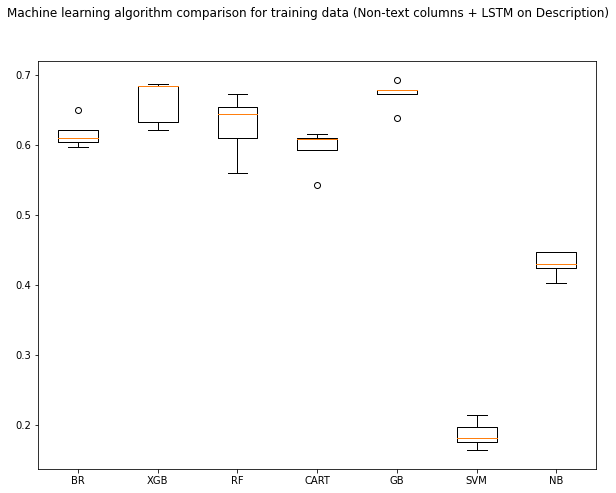

In [68]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10,7.5))
fig.suptitle('Machine learning algorithm comparison for training data (Non-text columns + LSTM on Description)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# LSTM +XGBoost

In [69]:
# Hyper Parameter Tuning for full data
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
seed=42
xgb_pipe_steps = [('lstm_full_pipeline',lstm_full_pipeline),
                  ('scaler',StandardScaler()),
                 ('XGB', xgb.XGBClassifier(random_state=seed ))
            ]

check_params= {
    'XGB__max_depth': [6,7], 
    'XGB__min_child_weight' : [2,3],
    'XGB__n_estimators' : [100],
    'XGB__eta' : [0.003],
    'XGB__learning_rate' : [0.04,0.05],
}
xgb_pipeline = Pipeline(xgb_pipe_steps)

In [70]:
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")


print ("Start Fitting Training Data")
for cv in tqdm(range(4,5)):
    create_grid = GridSearchCV(xgb_pipeline, param_grid=check_params, cv=cv)
    create_grid.fit(X_train, y_train)
    print ("score for %d fold CV := %3.2f" %(cv, create_grid.score(X_val, y_val)))
    print ("!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!")
    print (create_grid.best_params_)
    lstm_xgb_best_model=create_grid.best_estimator_
    print("LSTM+ XGB Best Model :",lstm_xgb_best_model)
  

print ("out of the loop")

Start Fitting Training Data


Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lst

In [71]:
import pickle
from pickle import dump
dump(lstm_xgb_best_model, open('lstm_xgb_lstm_full_model.pkl', 'wb'))

In [72]:
print(X_test.shape)
# X_test_tr=lstm_full_pipeline.fit_transform(X_test)
lstm_pred_model = pickle.load(open('lstm_xgb_lstm_full_model.pkl', 'rb'))
lstm_pred = lstm_pred_model.predict(X_test)
print(lstm_pred)

(316, 10)
Loaded lstm_pred_model from disk
[2 3 4 0 1 4 0 2 3 1 0 0 4 4 3 3 1 1 3 0 4 0 3 3 0 3 4 4 0 3 0 0 3 3 1 2 1
 0 2 3 3 1 1 1 2 3 4 4 4 1 0 2 3 4 0 4 1 4 1 3 3 4 1 4 4 4 4 4 0 2 1 3 3 3
 3 2 4 4 3 4 4 0 3 3 1 2 2 1 3 3 0 1 3 3 4 0 3 2 1 0 1 2 1 0 3 4 1 3 3 3 0
 3 3 0 4 4 2 2 2 4 3 3 1 3 3 0 3 3 0 1 3 0 1 4 0 4 1 4 3 2 2 3 4 3 0 4 2 0
 3 0 4 3 3 3 3 3 3 0 1 3 2 1 3 3 1 4 3 3 3 2 3 2 3 1 2 0 3 4 3 3 4 4 4 2 4
 4 3 4 4 4 2 0 2 1 3 0 1 3 3 0 2 1 1 2 2 0 1 2 4 3 4 2 1 1 1 2 4 0 2 4 4 3
 2 3 4 1 4 0 0 1 0 2 3 1 3 4 4 1 4 3 2 1 0 1 3 0 3 3 4 3 4 3 3 4 4 4 2 4 3
 4 2 1 1 2 2 3 2 0 3 4 4 0 3 2 4 3 3 4 3 1 1 4 4 0 4 3 4 0 4 0 3 2 4 3 3 4
 1 1 3 2 2 1 3 2 2 3 2 4 4 4 3 0 3 3 4 1]


In [ ]:
lstm_pred_model = pickle.load(open('lstm_xgb_lstm_full_model.pkl', 'rb'))
lstm_pred = lstm_pred_model.predict(X_test)  

Loaded lstm_pred_model from disk


In [74]:
import pickle
lstm_pred_model = pickle.load(open('lstm_xgb_lstm_full_model.pkl', 'rb'))
#lstm_pred = lstm_pred_model.predict(X_test)
print(lstm_pred_model)

Pipeline(memory=None,
         steps=[('lstm_full_pipeline',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('datetransform',
                                                  Pipeline(memory=None,
                                                           steps=[('date_info_split',
                                                                   TemporalVariableEstimator(variables=['Date']))],
                                                           verbose=False),
                                                  ['Date']),
                                                 ('imputer',
                                                  Pipeline(memory=None,
                                                           steps=[('risk_imputer',
                                                              

In [75]:
print(accuracy_score(y_test,lstm_pred))

0.6424050632911392


In [ ]:
FinalModelPredictions(X_test)

FinalModelPredictions(variables=None)

In [ ]:
acc_level_preds=final_preds_pipeline.fit_transform(X_test)
print(acc_level_preds)

# LSTM+ XGBoost classification report

In [76]:
from sklearn.metrics import classification_report
print (classification_report(y_test, lstm_pred_model.predict(X_test)))

Loaded lstm_pred_model from disk
              precision    recall  f1-score   support

           0       0.78      0.51      0.62        70
           1       0.63      0.47      0.54        68
           2       0.38      0.40      0.39        45
           3       0.50      0.75      0.60        64
           4       0.91      1.00      0.95        69

    accuracy                           0.64       316
   macro avg       0.64      0.63      0.62       316
weighted avg       0.66      0.64      0.64       316

